# Prédiction de la demande en électricité
<img src="Images/header_image.jpg" width=750>

# Objectif

Mon but est de déterminer la consommation en électricité pour la France sur une période d'un an. Pours les industriels de l'énergie, ajuster l'offre en fonction de la demande est important. En effet, il n'existe actuellement pas de méthode pour stocker de l'électricité en masse et les électrons se déplacent à la vitesse de la lumière. En outre, la demande en électricité est influencée par de nombreux facteurs tels que la météo.

Sources :
- https://www.youtube.com/watch?v=ypD6f4K0LTU
- https://business.weather.com/products/load-forecasts

# Les données

- Données de consommation d'électricité mensuelles : 
   - Institution fournisant les données :  Le *RTE* (*Réseau de transport et d'électricité*)
     - "RTE a été créé le 1er juillet 2000 avec pour missions d’entretenir, d’exploiter et de développer le réseau de transport d’électricité à haute et très haute tension de manière indépendante. C'est à cette époque un service d’EDF, avec une gestion, une comptabilité et un management séparés. Il s'agit de préparer l’ouverture du marché de l’électricité et l’arrivée de nouveaux producteurs."
     - "Le 1er septembre 2005, nous devenons une filiale du Groupe EDF, en application de la loi du 9 août 2004 relative au service public de l’électricité et du gaz et aux entreprises électriques et gazières. L’obligation d’indépendance de RTE vis-à-vis du reste du Groupe est réaffirmée et garantit la neutralité de RTE au regard de l’ensemble des producteurs d’électricité. Elle passe par un code de bonne conduite, dont le respect est vérifié annuellement par la Commission de Régulation de l’Énergie (CRE)."
   - Nom fichier : *eCO2mix_RTE_energie_M.xls.xlsx*
   - Lien source : http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement
   - Clés primaires :
     - Mois	
     - Qualité
     - Territoire
   - Période : Janvier 2010 à Décembre 2018 inclus 
- Données météo pour corriger les données de l'effet température : 
   - Institution fournisant les données :  Cegibat
     - "Cegibat, le centre d'expertise de GRDF, a pour mission d’informer et d’outiller l’ensemble des professionnels du bâtiment (bureaux d'études, installateurs, architectes, directeurs techniques, responsables de patrimoine, responsables énergie, exploitants…) sur la réglementation gaz naturel et l’efficacité énergétique." 
   - Nom du fichier : *calcul_DJU_chauffage.xlsx*
   - Lien source : https://cegibat.grdf.fr/simulateur/calcul-dju
   - Clés primaire : 
     - Année
   - Méthode de calcul : "Professionnels de l'énergie"
   - Température de référence : 18°C
   - Station météo : Roissy
   - Période : Janvier 2009 à Décembre 2018 inclus 

# Mission 0 : chargement et découverte des données

Nous allons essayer de répondre aux questions suivantes :
- Combien de lignes y a-t-il dans le jeu de données ?
- Combien de colonnes y a-t-il ?
- De quels types de données sont les champs?
- Les données sont-elles complètes? Y a-t-il des valeurs nulles? Devons-nous déduire des valeurs?
- Quelle est la définition des variables?
- Quelles sont les réserves concernant les données?

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data Viz
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

# Modélisation
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from scipy.optimize import minimize # for function minimization

# Autres
import copy
from itertools import product
from tqdm import tqdm_notebook

## Découverte du fichier de consommation d'électricité

In [2]:
raw_df_energy =  pd.read_excel("Data/eCO2mix_RTE_energie_M.xls.xlsx")

raw_df_energy.info()
raw_df_energy.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 22 columns):
Mois                                        985 non-null object
Qualité                                     985 non-null object
Territoire                                  985 non-null object
Production totale                           985 non-null int64
Production nucléaire                        620 non-null float64
Production thermique totale                 985 non-null int64
Production thermique charbon                682 non-null float64
Production thermique fioul                  985 non-null int64
Production thermique gaz                    985 non-null int64
Production hydraulique                      985 non-null int64
Production éolien                           985 non-null int64
Production solaire                          985 non-null int64
Production bio-énergies                     985 non-null int64
Consommation totale                         985 non-null int64
Solde 

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bio-énergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges aves la Suisse,Echanges avec l'Allemagne et la Belgique
0,0000-00,Données consolidées,Grand-Est,7296,5505.0,864,153.0,8,701,537,...,70,3364,3876.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données définitives,Nouvelle-Aquitaine,4523,3740.0,26,NaN,9,16,162,...,131,3222,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données définitives,Auvergne-Rhône-Alpes,8890,5946.0,32,4.0,17,10,2632,...,79,5010,3658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données définitives,Bourgogne-Franche-Comté,152,NaN,19,0.0,0,19,19,...,20,1533,-1383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données définitives,Bretagne,197,NaN,3,NaN,3,0,46,...,37,1493,-1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000-00,Données définitives,Centre-Val de Loire,6346,6191.0,0,NaN,0,0,1,...,34,1299,5047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0000-00,Données définitives,France,41255,29938.0,2683,582.0,206,1893,5291,...,809,34585,6011.0,7720.0,1708.0,1300.0,1746.0,1703.0,-124.0,1385.0
7,0000-00,Données définitives,Ile-de-France,148,NaN,5,0.0,4,1,4,...,119,4902,-4753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0000-00,Données définitives,Occitanie,2398,823.0,0,NaN,0,0,1049,...,59,2923,-688.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0000-00,Données définitives,Normandie,5554,5222.0,204,57.0,23,123,9,...,44,1924,3629.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_energy = raw_df_energy[['Mois', 'Qualité', 'Territoire', 'Consommation totale']]
df_energy = df_energy[df_energy['Territoire'] == "France"]
df_energy = df_energy[df_energy['Mois'] != "0000-00"]
df_energy["Mois"] = pd.to_datetime(df_energy['Mois']).dt.to_period('M')

df_energy.info()
df_energy.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 13 to 978
Data columns (total 4 columns):
Mois                   108 non-null period[M]
Qualité                108 non-null object
Territoire             108 non-null object
Consommation totale    108 non-null int64
dtypes: int64(1), object(2), period[M](1)
memory usage: 4.2+ KB


,Mois,Qualité,Territoire,Consommation totale
13,2010-01,Données consolidées,France,56342
14,2010-02,Données consolidées,France,48698
15,2010-03,Données consolidées,France,48294
16,2010-04,Données consolidées,France,38637
17,2010-05,Données consolidées,France,37284
18,2010-06,Données consolidées,France,34567
19,2010-07,Données consolidées,France,36031
20,2010-08,Données consolidées,France,33069
21,2010-09,Données consolidées,France,35104
22,2010-10,Données consolidées,France,40918


In [4]:
# Doublons
df_energy['Mois'].describe()

count         108
unique        108
top       2012-08
freq            1
Name: Mois, dtype: object

Il n'y a pas de doublons, ni de valeurs manquantes de le dataframe "df_energy".

----------

Nous sommes intéressés seulement par l'évolution de l'attribut "consommation totale". Selon le document de synthèse de *RTE*  (le lien est [ici](https://www.rte-france.com/fr/article/bilans-electriques-nationaux)), la consommation en électricité est exprimée en gigawatt-heure (GWh). On utilise plus communément le kilowatt-heure, un kWh équivaut à 1 kilowatt (1 kW) de puissance maintenue pendant 1 heure, soit 3,6 mégajoules.

In [5]:
# Supression des colonnes inutiles
df_energy = df_energy[['Mois', 'Consommation totale']]
df_energy = df_energy.rename(columns={'Consommation totale': 'conso(GWh)',
                                      'Mois': 'mois'})

df_energy.info()
df_energy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 13 to 978
Data columns (total 2 columns):
mois          108 non-null period[M]
conso(GWh)    108 non-null int64
dtypes: int64(1), period[M](1)
memory usage: 2.5 KB


,mois,conso(GWh)
13,2010-01,56342
14,2010-02,48698
15,2010-03,48294
16,2010-04,38637
17,2010-05,37284


## Découverte du fichier des données météo


In [6]:
raw_df_weather = pd.read_excel("Data/calcul_DJU_chauffage.xlsx", skiprows=11)

raw_df_weather.info()
raw_df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 14 columns):
Unnamed: 0    11 non-null int64
JAN           11 non-null float64
FÉV           11 non-null float64
MAR           11 non-null float64
AVR           11 non-null float64
MAI           11 non-null float64
JUN           11 non-null float64
JUI           11 non-null float64
AOÛ           11 non-null float64
SEP           11 non-null float64
OCT           11 non-null float64
NOV           11 non-null float64
DÉC           11 non-null float64
Total         11 non-null float64
dtypes: float64(13), int64(1)
memory usage: 1.3 KB


,Unnamed: 0,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.3
1,2018,324.9,453.6,333.6,146.3,97.5,34.6,6.2,18.9,71.7,149.2,297.6,346.0,2280.1
2,2017,499.6,298.6,227.9,227.2,102.5,29.8,20.0,28.5,82.0,122.4,302.9,390.4,2331.6
3,2016,384.6,341.8,352.1,244.5,125.9,52.1,23.6,23.2,34.6,198.4,310.3,418.6,2509.7
4,2015,414.0,388.3,307.4,187.5,125.0,55.2,25.3,23.3,101.6,202.4,212.5,256.1,2298.5


In [7]:
df_weather = raw_df_weather.rename(columns={'Unnamed: 0': 'Année',
                                            "JAN" : "01",
                                            "FÉV" : "02",
                                            "MAR" : "03",
                                            "AVR" : "04",
                                            "MAI" : "05",
                                            "JUN" : "06",
                                            "JUI" : "07",
                                            "AOÛ" : "08",
                                            "SEP" : "09",
                                            "OCT" : "10",
                                            "NOV" : "11",
                                            "DÉC" : "12"})
df_weather.drop(columns=['Total'], inplace=True)
df_weather.columns

Index(['Année', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12'],
      dtype='object')

In [8]:
df_weather = pd.melt(df_weather, 
                     id_vars=['Année'], 
                     value_vars=['01', '02', '03', '04', '05', '06', 
                                 '07', '08', '09', '10','11', '12'])

df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
Année       132 non-null int64
variable    132 non-null object
value       132 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ KB


,Année,variable,value
0,2019,01,0.0
1,2018,01,324.9
2,2017,01,499.6
3,2016,01,384.6
4,2015,01,414.0


L'attribut "value" correspond aux DJU servant à corriger les données de l'effet température. Le degré jour :
> est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18 °C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

Plus le nombre de DJU est important, plus le climat a été froid sur la période étudiée. Il existe deux méthodes pour calculer les DJU :
- Méthode météo : DJU = 18 - (température_min + température_max) / 2
- Méthode professionnels de l'énergie. Je ne la détaillerai pas ici, car elle est plus complexe. J'ai choisi cette dernière pour ce projet d'analyse de données.

Sources :
- https://cegibat.grdf.fr/simulateur/calcul-dju
- http://services.meteofrance.com/e-boutique/climatologie/dju-detail.html
- https://www.abcclim.net/degres-jour-dju.html

In [9]:
df_weather["mois"] = df_weather["Année"].astype(str) + '-' + df_weather["variable"].astype(str)
df_weather.drop(columns=['Année', 'variable'], inplace=True)
df_weather["mois"] = pd.to_datetime(df_weather['mois']).dt.to_period('M')
df_weather = df_weather.rename(columns={'value': 'dju'})

df_weather.info()
df_weather.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
dju     132 non-null float64
mois    132 non-null period[M]
dtypes: float64(1), period[M](1)
memory usage: 2.2 KB


,dju,mois
127,363.5,2013-12
128,362.7,2012-12
129,331.8,2011-12
130,551.1,2010-12
131,438.8,2009-12


## Création Dataframe 
Il est plus simple de regrouper les deux dataframes pour travailler efficacement dessus.

In [10]:
df_all = pd.merge(df_energy, df_weather, left_on='mois', right_on='mois', how='left')

df_all.index = df_all['mois']
df_all.info()
df_all.tail(10)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 108 entries, 2010-01 to 2018-12
Freq: M
Data columns (total 3 columns):
mois          108 non-null period[M]
conso(GWh)    108 non-null int64
dju           108 non-null float64
dtypes: float64(1), int64(1), period[M](1)
memory usage: 3.4 KB


,mois,conso(GWh),dju
mois,,,
2018-03,2018-03,48484,333.6
2018-04,2018-04,36236,146.3
2018-05,2018-05,33949,97.5
2018-06,2018-06,32553,34.6
2018-07,2018-07,34514,6.2
2018-08,2018-08,32384,18.9
2018-09,2018-09,32620,71.7
2018-10,2018-10,37052,149.2
2018-11,2018-11,43814,297.6


## Analyses univariées

In [11]:
df_all.describe()

,conso(GWh),dju
count,108.000000,108.000000
mean,40378.333333,202.495370
std,7266.069563,146.580197
min,31004.000000,6.200000
25%,33933.000000,59.625000
50%,37630.500000,186.800000
75%,46463.000000,325.600000
max,57600.000000,551.100000


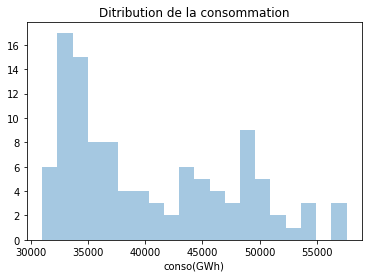

In [12]:
sns.distplot(df_all['conso(GWh)'], kde=False, bins=20)
plt.title("Ditribution de la consommation")
plt.show()

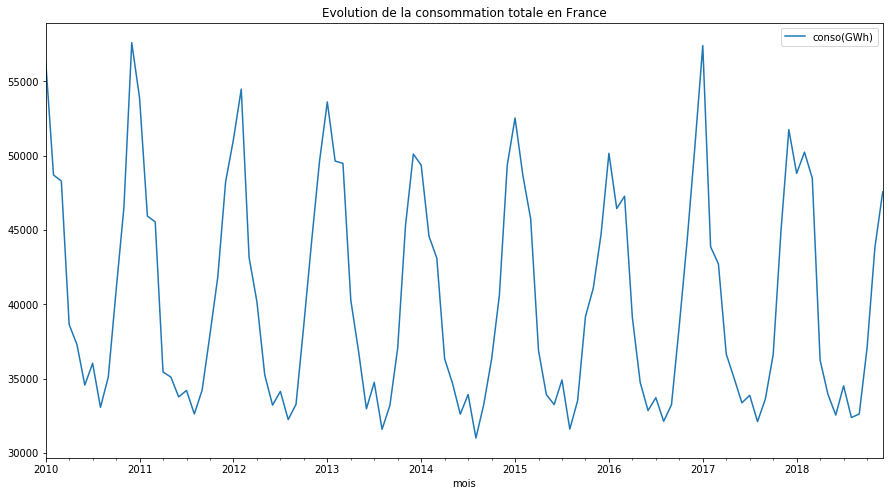

In [13]:
df_all[['mois','conso(GWh)']].plot('mois', figsize=(15,8))
plt.title("Evolution de la consommation totale en France")
plt.show()

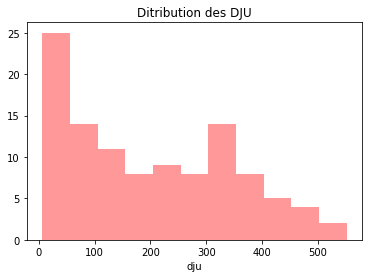

In [14]:
sns.distplot(df_all['dju'], kde=False, bins=11, color="r")
plt.title("Ditribution des DJU")
plt.show()

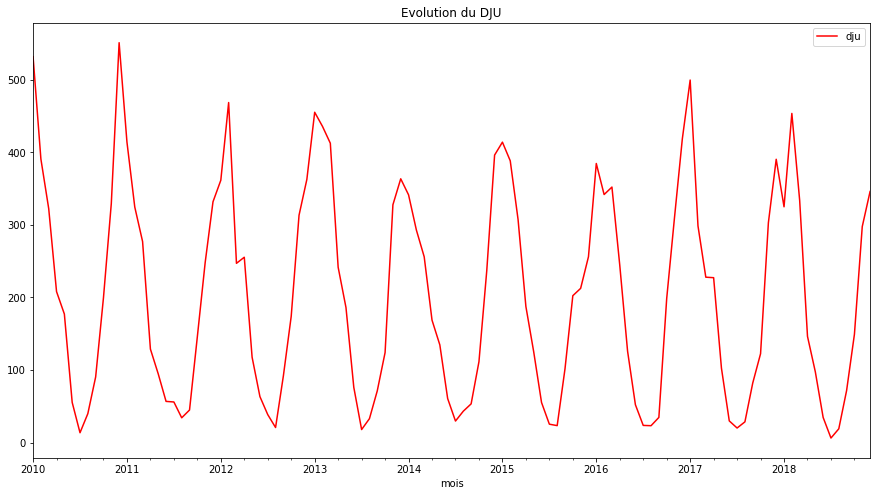

In [15]:
dju_not_null = df_all['dju'] != 0
df_all.loc[dju_not_null , ['mois','dju']].plot('mois', figsize=(15,8), color="r")
plt.title("Evolution du DJU")
plt.show()

Les graphiques de la consommation totale et de la DJU sont très proches, il semble qu'il y ait une forte corrélation entre ces deux variables. D'autre part, il ne semble pas avoir d'outliers dans les variables étudiées.

# Mission 1 : correction de la consommation mensuelle de l'effet température

Nous allons maintenant corriger les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.  Nous appelons cela, la correction climatique :
>La correction climatique consiste à pondérer les consommations de chauffage sur la base des données climatiques annuelles de la station météo. L’objectif est de rendre les années comparables entre elle, quelle qu’ait été la rudesse de l’hiver. En ramenant les consommations de chauffage à un climat de référence, caractérisé par les DJU, on supprime ainsi les variations imputables à la rigueur climatique.


Sources :
- http://www.gpso-energie.fr/conseils/analyser-ses-consommations-dju
- http://alpestat.com/lexique/html/_correction_climatique.html
- http://perso.ens-lyon.fr/lise.vaudor/autocorrelation-de-series-temporelles-ou-spatiales/
- https://www.youtube.com/watch?v=y5HG8ZQ_mfE&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=1
- https://www.quora.com/Why-cant-you-use-linear-regression-for-time-series-data
- https://www.quora.com/Data-Science-Can-machine-learning-be-used-for-time-series-analysis

## Application de la régression linéaire

Sources :
- https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
- https://pythonfordatascience.org/linear-regression-python/
- https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/

In [16]:
X_constant = sm.add_constant(df_all['dju'])
lin_reg = sm.OLS(df_all['conso(GWh)'], X_constant).fit()
lin_reg.summary()

C:\Users\CGRM\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conso(GWh)   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1886.
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           2.42e-69
Time:                        11:37:59   Log-Likelihood:                -954.57
No. Observations:                 108   AIC:                             1913.
Df Residuals:                     106   BIC:                             1919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.061e+04    277.226    110.420      0.000    3.01e+04    3.12e+04
dju           48.2334      1.111     43.424      0.000      46.031      50.436
==============================================================================
Omnibus:                        0.641   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.365
Skew:                           0.133   Prob(JB):                        0.833
Kurtosis:                       3.102   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Respect des hypothèses de la  RL

La régression linéaire fait plusieurs hypothèses sur les données, telles que:
- Variables explicatives quantitatives - Les données doit être quantitatives ; c'est le cas dans notre projet.
- Linéarité des données - La relation entre le(s) prédicteur(s) et le variable prédite est supposée être linéaire.
- Normalité des résidus - Les erreurs de prédiction sont supposées être normalement distribuées.
- Homogénéité de la variance des résidus - Les résidus sont supposés avoir une variance constante (homoscédasticité). 
- Indépendance des résidus - Les résidus ne doivent pas s'influencer les uns des autres.

Sources :
- https://boostedml.com/2018/08/testing-linear-regression-assumptions-the-kaggle-housing-price-dataset.html
- https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/
- https://pythonfordatascience.org/linear-regression-python/

### Linéarité des données

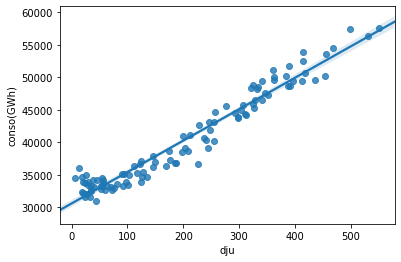

In [17]:
sns.regplot(x="dju", y="conso(GWh)", data=df_all)
plt.show()

Visuellement, la relation entre les DJU et la consommation paraît linéaire.

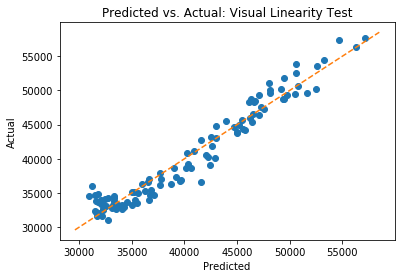

In [18]:
def abline(slope, intercept):
    """Plot a line from slope and intercept, borrowed from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# fit an OLS model to data
lin_reg = sm.OLS(df_all['conso(GWh)'], X_constant).fit()
# predict y values for training data
y_hat = lin_reg.predict()
# plot predicted vs actual
plt.plot(y_hat, df_all['conso(GWh)'],'o')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual: Visual Linearity Test')
abline(1,0)
plt.show()

In [19]:
sms.linear_harvey_collier(lin_reg)

Ttest_1sampResult(statistic=-1.158421070042484, pvalue=0.24934543645980192)

L'hypothèse nulle du test de Harvey-Collier est que la régression est correctement modélisée en étant linéaire. Dans notre cas, la valeur-p étant largement supérieur à 1%, nous ne rejetons pas l'hypothèse nulle : il y a bien une relation linéaire entre le DJU et la consommation totale.

### Normalité des résidus

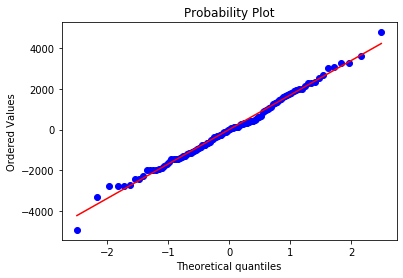

In [20]:
# Quantiles of the residuals against the quantiles of the normal distribution
resid = lin_reg.resid
scipystats.probplot(resid, dist="norm", plot=pylab)
pylab.show()

In [21]:
print(stats.diagnostic.kstest_normal(resid, pvalmethod='approx'))

(0.05736260834897666, 0.2)


Les quantiles des résidus  ont l'air de suivre les quantiles de la distribution normale sur le graphique. De plus, la p-valeur pour le test de Kolmogorov-Smirnov est de 20%, nous ne rejetons pas l'hypothèses nulle de normalité. Par conséquent, les résidus suivent une loi normale.

### Homogénéité de la variance des résidus

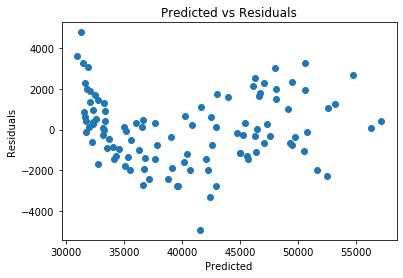

In [22]:
plt.scatter(lin_reg.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.show()

In [23]:
# https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
stats.diagnostic.het_white(lin_reg.resid, lin_reg.model.exog)

(0.04751111636933647,
 0.9765243839788765,
 0.02310584624018381,
 0.9771640166793769)

Le test de White est un test statistique qui teste si la variance des erreurs d'un modèle de régression est constante (homoscédasticité). Au vu de la p-valeur, nous en déduisons que la variance des erreurs du modèle de régression est constante.

### Indépendance des résidus

In [24]:
stools.durbin_watson(lin_reg.resid)

1.7781530043780844

La statistique du test de Durbin-Watson indique l'autocorrélation des résidus. Cette statistique est toujours comprise entre 0 et 4. Plus la statistique est proche de 0, plus l'auto-corrélation positive est avérée. Plus on se rapproche de 4, plus il y a de preuves d'une auto-corrélation négative. Proche de 2, la statistique indique qu'il n'y a pas d'auto-corrélation.

Dans ce projet, cette statisitique est proche de 2, les résidus sont donc indépendants.

### Significativité des paramètres

In [25]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conso(GWh)   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1886.
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           2.42e-69
Time:                        11:38:00   Log-Likelihood:                -954.57
No. Observations:                 108   AIC:                             1913.
Df Residuals:                     106   BIC:                             1919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.061e+04    277.226    110.420      0.000    3.01e+04    3.12e+04
dju           48.2334      1.111     43.424      0.000      46.031      50.436
==============================================================================
Omnibus:                        0.641   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.365
Skew:                           0.133   Prob(JB):                        0.833
Kurtosis:                       3.102   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Les coefficients décrivent la relation mathématique entre chaque variable indépendante et la variable dépendante. Les valeurs-p des coefficients indiquent si ces relations sont statistiquement significatives. Ici, les paramètres sont significatifs, les p-valeurs sont largement inférieurs à 1%.

R² est le pourcentage de variance de la variable cible qui est expliquée par la régression linéaire. 95% de la variance expliquée dans notre cas. Les autres facteurs non considérés dans le modèle sont responsables de 5% de la variance.


## Correction de la consommation mensuelle

L'équation de la régression linéaire pour la consommation est la suivante :
>conso = 𝛼 + 𝛽.dju(**valeur**) + 𝜖(**résidus**)

Pour avoir la consommation mensuelle corrigée de l'effet température (dues au chauffage électrique) , il suffit de passer à l'opération suivante : 
>conso_revue =  conso - 𝛽.dju(**valeur**)

In [26]:
df_all['conso_revue(GWh)'] = df_all['conso(GWh)'] - lin_reg.params[1] * df_all['dju']
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 108 entries, 2010-01 to 2018-12
Freq: M
Data columns (total 4 columns):
mois                108 non-null period[M]
conso(GWh)          108 non-null int64
dju                 108 non-null float64
conso_revue(GWh)    108 non-null float64
dtypes: float64(2), int64(1), period[M](1)
memory usage: 4.2 KB


,mois,conso(GWh),dju,conso_revue(GWh)
mois,,,,
2010-01,2010-01,56342,531.8,30691.462976
2010-02,2010-02,48698,390.7,29853.199670
2010-03,2010-03,48294,322.3,32748.366147
2010-04,2010-04,38637,208.0,28604.446970
2010-05,2010-05,37284,177.1,28741.859897


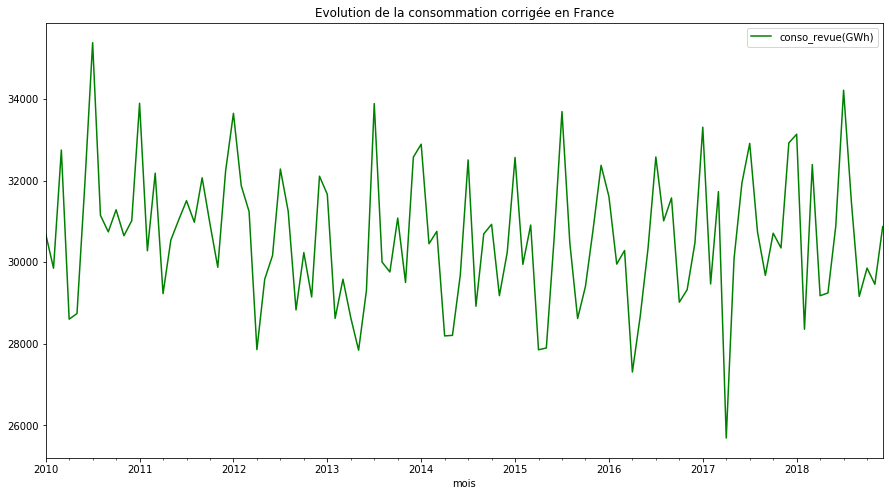

In [27]:
df_all[['mois','conso_revue(GWh)']].plot('mois', figsize=(15,8), color='g')
plt.title("Evolution de la consommation corrigée en France")
plt.show()

In [28]:
df_all.loc[df_all['conso_revue(GWh)'].idxmin()]

mois                2017-04
conso(GWh)            36650
dju                   227.2
conso_revue(GWh)    25691.4
Name: 2017-04, dtype: object

Le mois d'avril 2017 est un outlier. Dans son analyse de la consommation du mois d'avril 2017, voici ce qu'indique la *RTE* :
>La consommation brute est en recul par rapport à avril 2016 (-6,2%) du fait de températures plus douces. Bien que ce mois d’avril se soit révélé plus froid que la normale (-0,8°C) il a été en hausse par rapport au mois d’avril 2016 (+0,7°C). Corrigée de l’aléa climatique la consommation française annuelle d’électricité est en très légère diminution (-0,3%).

Source : https://www.rte-france.com/fr/eco2mix/analyses-mensuelles#

# Mission 2 : désaisonnalisation de la consommation

## Moyenne mobile

Nous allons effectuer une désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles. Selon l'Insee, une moyenne mobile :
>permet de « lisser » une série de valeurs exprimées en fonction du temps (série chronologique). Elle permet d'éliminer les fluctuations les moins significatives. On calcule des moyennes mobiles d'ordre 1, d'ordre 2, d'ordre 3, etc. L'ordre est le nombre de périodes (années, trimestres, mois...) sur lesquelles la moyenne mobile est calculée.

En clair, on utilise ce procédé pour faire apparaître la/les tendance(s) en effaçant la saisonnalité et le bruit aléatoire. Choisir le bon ordre est semblable au dilemme biais/variance en *machine learning*. Il existe plusieurs types de moyennes glissantes :
- Arithmétique / pondérée / exponentielle
- Centrée ou non-centrée

Autres liens :
- https://medium.com/fintechexplained/forecasting-time-series-explained-5cc773b232b6
- https://www.youtube.com/watch?v=l5A0ZDMzsv8

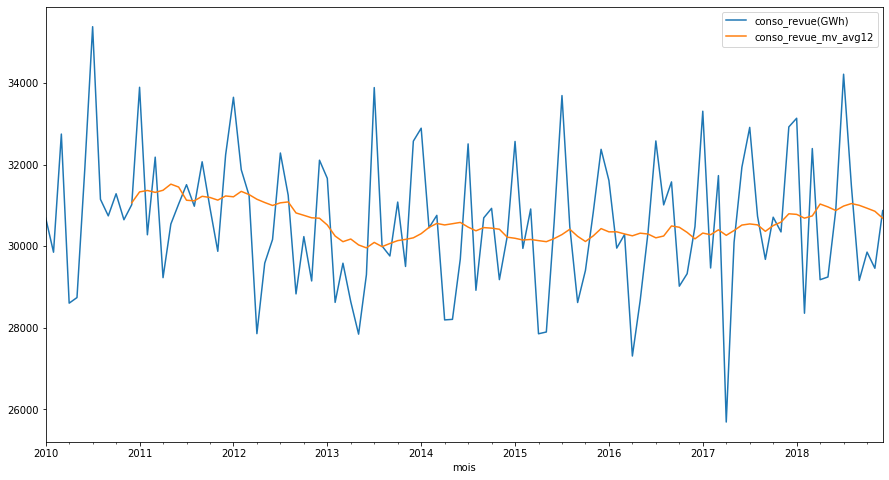

In [29]:
df_all['conso_revue_mv_avg12'] = df_all['conso_revue(GWh)'].rolling(window=12).mean()
df_all[['mois', 'conso_revue(GWh)', 'conso_revue_mv_avg12']].plot('mois', figsize=(15,8))
plt.show()

J'ai choisi d'utiliser une moyenne mobile non-centrée d'ordre 12, car il y a 12 mois dans une année et car la courbe est visuellement explicite.

Nous pouvons remarquer qu'il y a une légère baisse de 2010 à 2014 de la consommation, puis une stabilisation de celle-ci, bien qu'elle semble remonter à partir de mi-2017. Cela correspond aux conclusions du rapport *Bilan électrique 2018* de la *RTE* :
>Une tendance de long terme à la stabilisation de la consommation totale d’électricité s’observe depuis plusieurs années et traduit globalement une meilleure maîtrise de la consommation malgré une utilisation croissante d’appareils électriques.

## Décomposition de la tendance,  de la saisonalité et du bruit

Pour simplifier une série temporelle est composée de 4 choses : niveau, tendance, saisonalité et bruit. Nous allons maintenant faire apparaître ces éléments les uns à côté des autres.

Sources :
- https://www.datavedas.com/time-series-in-python/
- https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788290227

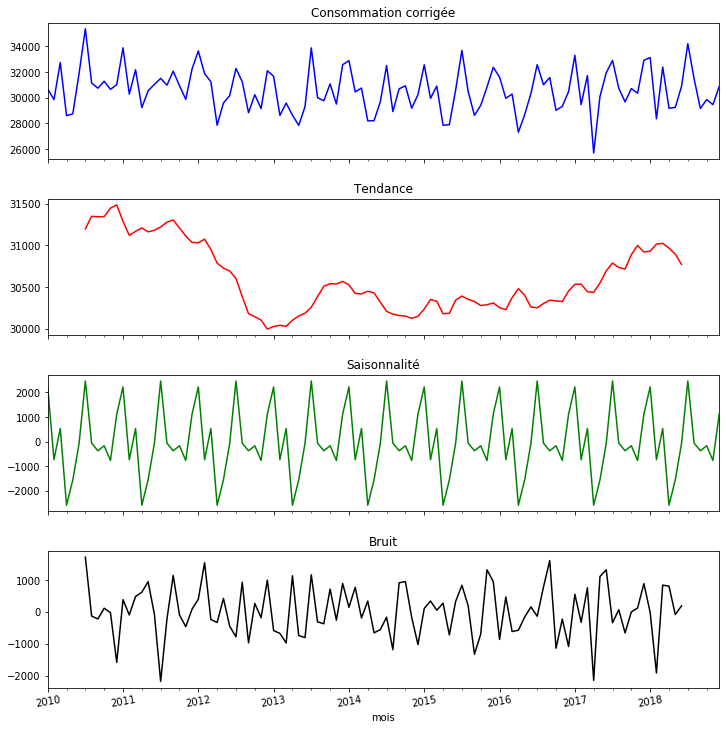

In [30]:
import statsmodels.tsa as tsa

# seasonal_decompose does not accept PeriodIndex
conso_revue = copy.deepcopy(df_all['conso_revue(GWh)'])
conso_revue.index = conso_revue.index.to_timestamp()

decomposition = tsa.seasonal.seasonal_decompose(conso_revue)
 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(10, 10)


conso_revue.plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Consommation corrigée')

pd.Series(data=trend, index=conso_revue.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Tendance')

pd.Series(data=seasonal, index=conso_revue.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Saisonnalité')

pd.Series(data=residual, index=conso_revue.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Bruit')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.xticks(rotation=10)
plt.show()

L'algorithme a usé d'une moyenne mobile centrée d'ordre 12. Nous pouvons tirer les mêmes conclusions que sur le graphique précédent. Concernant la saisonnalité, il semble qu'elle soit annuelle et additive. Ces informations sont particulièrement cruciales pour les modélisations ultérieures.

(0.0604577663158713, 0.2)


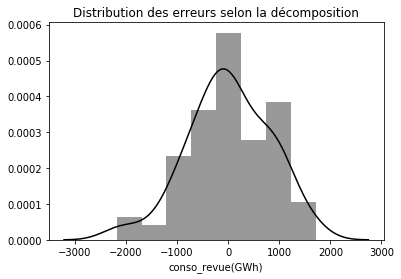

In [31]:
sns.distplot(residual.dropna(), color="black")
plt.title("Distribution des erreurs selon la décomposition")
print(stats.diagnostic.kstest_normal(residual.dropna(), pvalmethod='approx'))

Le test de Kolmogorov-Smirnov indique que la distribution des résidus suit une loi normale.

# Missions 3 : prévision de la consommation sur un an

Dans cette partie, nous effecturons une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

## Méthode de Holt Winters

Le lissage exponentiel de Holt-Winters est un triple lissage exponentiel capable de capturer la tendance et la saisonnalité d'une série temporelle (qu'elles soient multiplicatives ou additives).  Cette technique est populaire et peu gourmande en calculs. Comme le lissage exponentiel simple et double, la méthode de Holt-Winters donne aux observations passées un poids décroissant exponentiellement avec leur ancienneté.

Les constantes (alpha, beta et theta) contrôlent la vitesse d'apprentissage du modèle :
- *alpha* - Ce paramètre spécifie le coefficient pour le lissage de niveau. *Alpha* est similaire à une moyenne mobile des observations, il change l'estimation de niveau local. Plus *alpha* est grand, plus il donne de poids aux données récentes. 
- *beta* - C'est le coefficient de la tendance. On peut l'interpréter comme étant la moyenne mobile des différences entre les observations consécutives. Plus *beta* est grand, plus il donne de poids aux données récentes.
- *gamma* - C'est le facteur de lissage pour la composante saisonnière. Plus *gamma* est grand, plus il donne de poids aux données récentes.

Ces trois éléments prennent une valeur entre 0 et 1, il faut les faire varier afin de trouver le meilleur modèle. Nous automatisersons cette recherche via un algortithme.

Attention, la méthode de Holt-WInters fait quelques hypothèses sur le jeu de données :
- Une seule tendance.
- La périodicité des saisons n'évolue pas au cours du temps. - Nous sommes dans le cas d'une saisonnalité mensuelle. Il faudra fournir cette information à l'algorithme.
- Pas de données aberrantes.
- Pas de structure autorégressive ou de modèle adaptatif.
- Le futur se calque sur le passé.
- Les résidus du modèle ont une variance constante.

Sources :
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
- https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/
- https://www.youtube.com/watch?v=mrLiC1biciY&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=19
- https://mlcourse.ai/articles/topic9-part1-time-series/
- https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
- https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
- https://stats.stackexchange.com/questions/193901/interpretation-of-level-trend-and-seasonal-indices-in-holt-winters-exponential

In [32]:
# https://mlcourse.ai/articles/topic9-part1-time-series/
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

Avant de construire le modèle, discutons d’abord comment estimer les paramètres du modèle automatiquement. Tout d'abord, nous choisirons une fonction de perte qui indiquera à quel point le modèle se rapproche des données. Ensuite, en utilisant une validation croisée adaptée pour les séries chrnonologiques (voir schéma ci-dessous), nous évaluerons la fonction de perte choisie pour les paramètres de modèle donnés, calculerons le gradient, ajusterons les paramètres de modèle, etc. afin de trouver le minimum global.

<img src="Images/time_series_cv.png">

In [33]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

La fonction de perte utilisée pour trouver le minimum global est l'erreur quadratique moyenne ("mean squared error" en anglais). Voici sa formule : $MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

D'autre part, nous allons utiliser les 4 derniers mois de 2018 comme test.

In [34]:
data = conso_revue[:-4] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 12 months
model = HoltWinters(data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 16, scaling_factor = 3)
model.triple_exponential_smoothing()

0.03496832373520614 0.0 0.25021544392929496


Le programme a trouvé le minimum global, les valeurs des différentes constantes sont :
- *alpha* = 0,035 - Paramètre quasi-nul, le modèle oublie peu le niveau.
- *beta* = 0,0 - C'est le coefficient le mois important des 3. Cela veut dire que rien n'est "oublié" pour la tendance
- *gamma* = 0,250 - Le modèle "oublie" plus rapidement les données concernant la saisonnalité.

Sources :
- https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/winters-method/interpret-the-results/all-statistics-and-graphs/

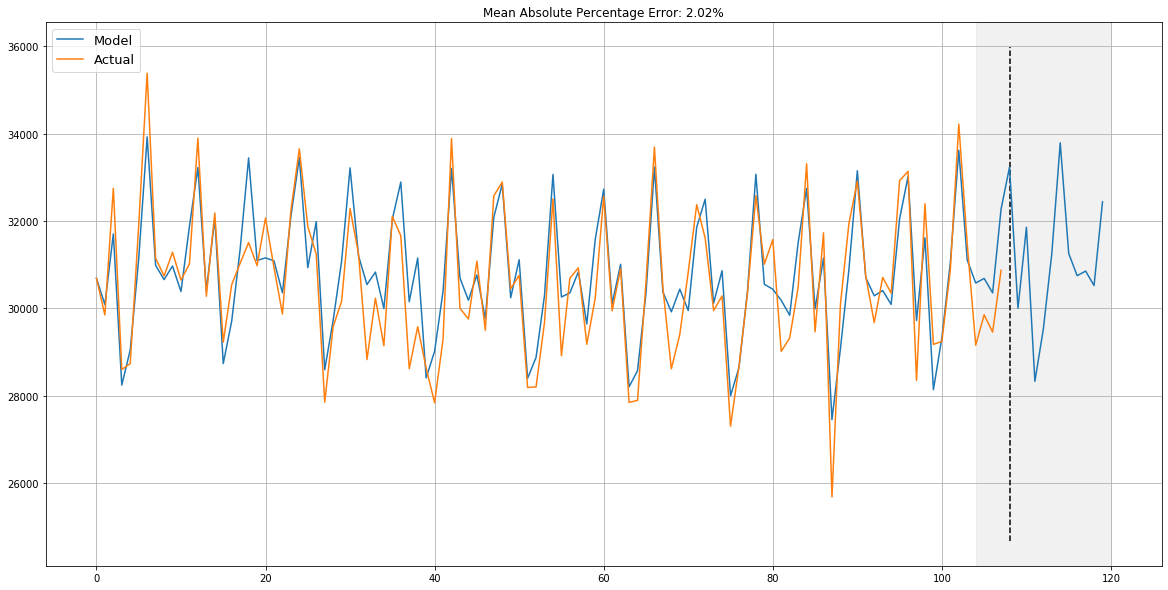

In [35]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-4, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);


plotHoltWinters(conso_revue, plot_intervals=False, plot_anomalies=False)

Il est utile de comparer les valeurs réelles et les prédictions du modèle. L'écart entre les deux constitue une indication indispensable de la précision d'une méthode. Dans ce projet, j'ai décidé d'utiliser une variation de l'*erreur absolue moyenne*, qui est l'écart moyen des valeurs prédites par rapport aux valeurs observées, le *pourcentage d'erreur moyenne absolue*. En effet, il est simple à comprendre et donne l'occasion de confronter les perfomances de plusieurs procédés facilement. Voici la formule de ces deux indicateurs :
- $MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$
- $MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$

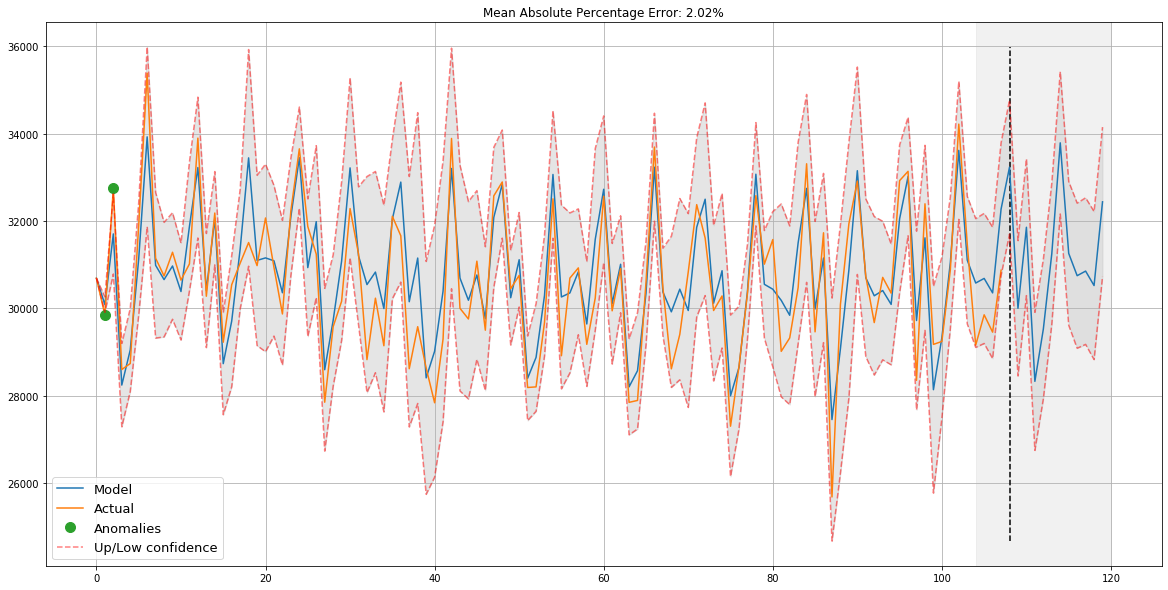

In [36]:
plotHoltWinters(conso_revue, plot_intervals=True, plot_anomalies=True)

Sur les deux graphiques, nous pouvons remarquer que notre modèle de Holt-Winters semble proche de la réalité. Cela est confirmé par le pourcentage pourcentage d'erreur moyenne absolue qui est faible (environ 2%). On remarque aussi que l'intervalle de confiance varie au cours du temps, c'est normal.

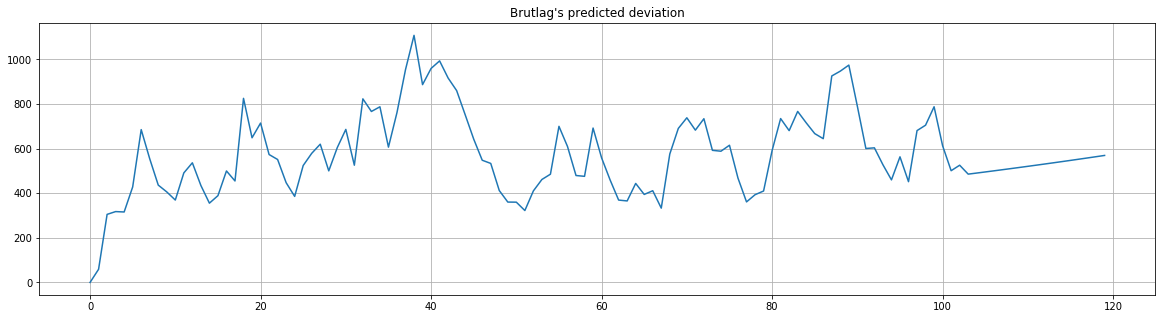

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")
plt.show()

Avant de passer à la méthdoe SARIMA, il est essentiel de comprendre la notion de stationnarité. L'infographie ci-dessous détaille bien ce concept :

<img src="Images/stationarity.png">

Sources :
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

## Méthode SARIMA
Nous allons maintenant utliser la méthode *SARIMA* ("Seasonnal AutoRegressive Integrated Moving Average" en anglais). Nous allons dans un premier temps parcourir ce modèle lettre par lettre:
- *AR(p)* - Un modèle similaire à une régression linéaire qui utilise la relation dépendante entre une observation et un certain nombre d'observations différées. $Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + \beta_{p}Y_{t-p} + \epsilon_{t}$
- *MA(q)* - Un modèle qui utilise la dépendance entre une observation et une erreur résiduelle d'un modèle à moyenne mobile appliqué à des observations décalées.

En combinant ces quatres lettres nous avons *ARMA(p, q)*. Voici sa formule $Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \beta_{p}Y_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{q}\epsilon_{t-q}$

Ensuite nous avons :
- *I(d)* - Utilisation de la différenciation d'observations afin de rendre la série temporelle stationnaire et utiliser l'*ARMA*. En effet, l'ARMA présuppose que les données sont stationnaires. Le paramètre *d* correspond au nombre de fois que la différencation est effectuée.
  - d=0: pas de différenciation (pas de tendance) $y_{t} = Y_{t}$
  - d=1: une seule différenciation (tendance linéaire) $y_{t} = Y_{t} - Y_{t-1}$
  - d=2: double différenciation $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$

En ajoutant le *I*, nous formons l'*ARIMA(p, d, q)*.

Il me manque plus que la saisonnalité :
- *S(s)* - Est égale à longueur d'une saison.

Enfin trois paramètres supplémentaires sont nécessaires pour la méthode *SARIMA* :
- *P*  - pareil que *p* mais pour la composante saisonnière.
- *Q* - pareil que *q* mais pour la composante saisonnière.
- *D* - concerne l'intégration de la composante saisonnière, prend la valeur 0 (pas de différenciation) ou 1 (différenciation simple).

Pour résumer : $SARIMA(p, d, q)(P, D, Q, s)$. Pour choisir tous ces différents paramètres et faire des prédictions, il est judicieux de suivre le processus indiqué ci-dessous.

<img src="Images\arima_process.png">

Sources :
- https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#generated-statsmodels-tsa-statespace-sarimax-sarimax--page-root
- https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.minitab.com/fr-fr/Published-Articles/ARIMA%C2%A0--Comment-analyser-des-donn%C3%A9es-de-s%C3%A9rie-chronologique-diff%C3%A9remment%C2%A0-/
- https://people.duke.edu/~rnau/411arim2.htm
- https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

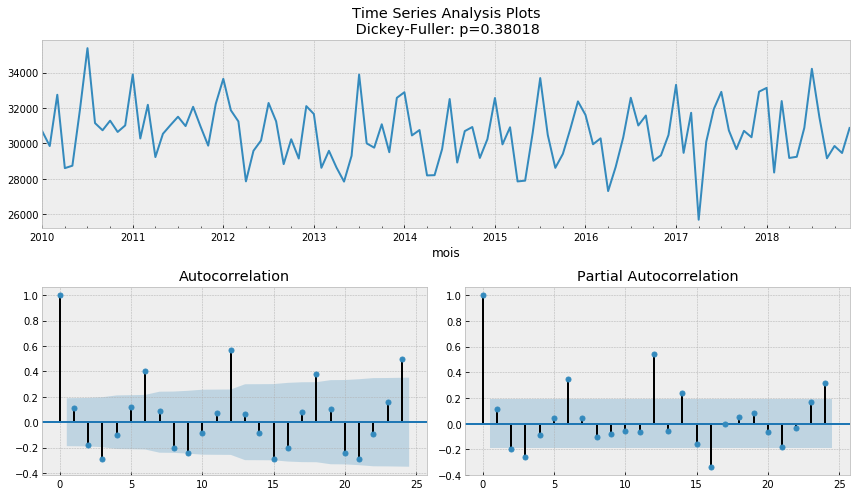

In [38]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        tsa.api.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        tsa.api.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(conso_revue, lags=24)

Le test de Dickey-Fuller a pour hyptohèse nulle que la série temporelle est non-stationnaire, cette hypothèse n'est pas rejetée pour l'évolution de la consommation totale.

Le deuxième graphique, l'ACF, nous permet de visualiser l'auto-Corrélation différenciée, c-à-d. les corrélations entre des valeurs qui sont séparées par k périodes. Ainsi, il décrit dans quelle mesure la valeur actuelle de la série est liée à ses valeurs antérieures. La saisonnalité annuelle est mis en évidence ici.

Le troisième graphique, le PACF ou fonction d’autocorrélation partielle est une mesure de la corrélation entre les observations d’une série temporelle séparées par k unités de temps (yt et yt – k), après ajustement pour tenir compte de la présence de tous les autres termes de retard plus court (yt – 1, yt). –2, ..., yt – k – 1).

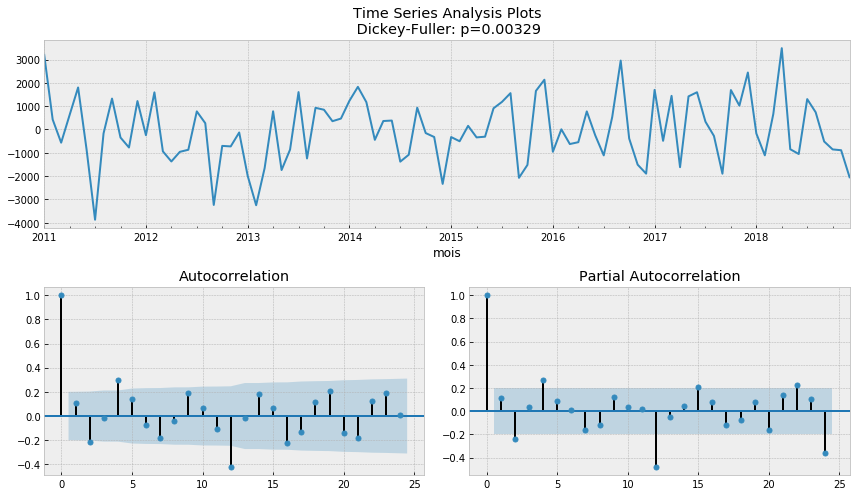

In [39]:
conso_diff = conso_revue - conso_revue.shift(12)
tsplot(conso_diff[12:], lags=24)

Avec un différenciation d'ordre 12, la série est stationnaire selon le test de Dickey-Fuller. Concernant le choix des paramètres suite à l'analyse :
- *p* Entre 2 et 5 selon le PACF 
- *q* Entre 2 et 5 selon l'ACF 
- *d*=0 Pas besoin d'enlever la tendance il n'y en a déjà plus.
- *s*=12
- *P* est certainement égal à 0 ou 1 selon le PACF
- *D*=1 car nous avons réalisé une différenciation saisonnière.
- *Q* est probablement 1 car le 12ème lag sur l'ACF est significatif mais pas le dernier.

Pour faciliter le choix des paramètres optimaux pour la SARIMA, nous allons l'automatiser via un algorithme.

In [40]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=0 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [41]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=tsa.statespace.sarimax.SARIMAX(conso_revue, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [42]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_


Wall time: 39.7 s


In [43]:
result_table.head()

,parameters,aic
0,"(3, 3, 1, 1)",1643.024556
1,"(3, 3, 0, 0)",1643.846488
2,"(4, 2, 0, 0)",1644.838599
3,"(3, 3, 1, 0)",1645.163669
4,"(3, 3, 0, 1)",1645.581587


In [44]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=tsa.statespace.sarimax.SARIMAX(conso_revue, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                   conso_revue(GWh)   No. Observations:                  108
Model:             SARIMAX(3, 0, 3)x(1, 1, 1, 12)   Log Likelihood                -812.512
Date:                            Sat, 02 Nov 2019   AIC                           1643.025
Time:                                    11:38:48   BIC                           1666.104
Sample:                                01-01-2010   HQIC                          1652.354
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3415      0.067     19.972      0.000       1.210       1.473
ar.L2         -1.3767      0.043   

Nous allons maintenant inspecter les résidus du modèle

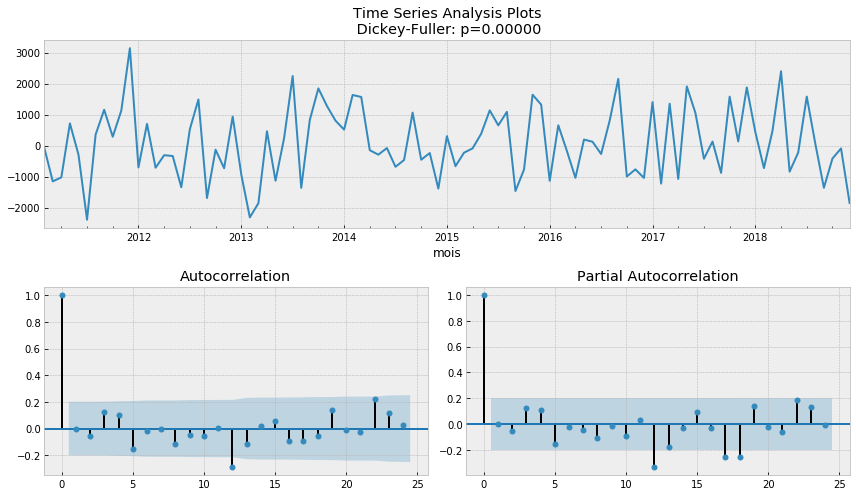

In [45]:
tsplot(best_model.resid[12+1:], lags=24)

Les résidus sont clairement stationnaires et il n'y a pas d'autocorrélation apparente. Nous pouvons prédire avec notre modèle

2019-01-01    33760.291237
2019-02-01    28824.553563
2019-03-01    31611.509063
2019-04-01    28292.205917
2019-05-01    29581.976331
2019-06-01    31557.762708
2019-07-01    33938.464713
2019-08-01    30646.746743
2019-09-01    29064.127654
2019-10-01    30467.741366
2019-11-01    29988.138784
2019-12-01    30635.225155
2020-01-01    33005.639580
Freq: MS, dtype: float64
2010-01-01             NaN
2010-02-01             NaN
2010-03-01             NaN
2010-04-01             NaN
2010-05-01             NaN
                  ...     
2019-09-01    29064.127654
2019-10-01    30467.741366
2019-11-01    29988.138784
2019-12-01    30635.225155
2020-01-01    33005.639580
Length: 121, dtype: float64


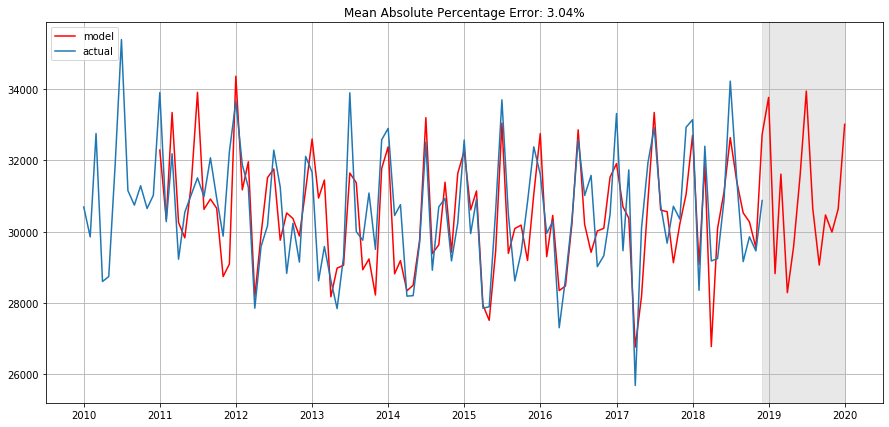

In [46]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.rename('actual', inplace=True)
    #data.rename(index={0: "actual"}, inplace=True)
    data = data.to_frame()
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    print(forecast)
    forecast = data.arima_model.append(forecast)
    print(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(conso_revue, best_model, 12)

Notre modèle a une erreur moyenne absolue de 3,04%.